In [29]:
import pandas as pd
from sympy import symbols, Eq, solve
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


FILENAME = "Drug_Use_Data_from_Selected_Hospitals.csv"
filepath = f"../data/{FILENAME}"
drug_use_df = pd.read_csv(filepath)

The first ~80 rows have a patient count that we can use to extrapolate counts of each condition. but it involves a bit of math, and I think we are better off doing analysis on the ratios (percentages)

If we see the row 
| sex   | Start Time | End Time   | setting | all drugs |
| ------| -----------| ---------- | ------- | ----------|
| female| 01/01/2020 | 01/31/2020 | ip      | 23.498389 |
| male  | 01/01/2020 | 01/31/2020 | ip      | 30.455556 |


You can see that the percentages don't add up to 100%. This is because row reads: Given all males admitted to the hospital as In Patients for this time period, 30.4555% were admitted for condition all_drugs.

In the end, I created 2 dataframes.
- 1st with data grouped by sex categories: drug_sex_df
- 2nd with data grouped by age categories: drug_age_df

we can do EDA on each

## Data Clean Up

### Create and cleanup base data

In [30]:
# set column names to lowercase
drug_use_df.columns = drug_use_df.columns.str.lower()
# set row data to lowercase
COLUMNS_TO_CONVERT_TO_LOWERCASE = ['setting', 'indicator', 'group', 'subgroup', 'measure']
for col in COLUMNS_TO_CONVERT_TO_LOWERCASE:
    drug_use_df[col] = drug_use_df[col].str.lower()

# round values to 4 decimal places
drug_use_df['value'] = drug_use_df['value'].round(4)

# Rename setting to be more readable
drug_use_df['setting'] = drug_use_df['setting'].replace({'ip': 'In Patient', 'ed': 'Emergency Department'})

# Convert start_time and end_time to datetime
drug_use_df['start_time'] = pd.to_datetime(drug_use_df['start_time'])
drug_use_df['end_time'] = pd.to_datetime(drug_use_df['end_time'])

# Grab the base data
base_drug_df = drug_use_df.iloc[:82]

# Remove extra columns
COLUMNS_TO_DROP_WITH_VALUE = ['figure', 'indicator', 'group', 'subgroup', 'measure']
base_drug_df_counts = base_drug_df.drop(columns=COLUMNS_TO_DROP_WITH_VALUE)

# Remove extra columns
COLUMNS_TO_DROP= ['figure', 'indicator', 'group', 'subgroup', 'measure', 'value']
base_drug_df = base_drug_df.drop(columns=COLUMNS_TO_DROP)

### Helper functions and constants

In [31]:
# Names of conditions in the rows we are converting to columns
BASE_DRUGS = ['All Drugs', 'All Opioids', 'Stimulants', 'Cannabis', 'Benzodiazepine']
BASE_DRUGS_CO_OCCURING = ['All Drugs and co-occurring disorders', 'All Opioids and co-occurring disorders', 'Stimulants and co-occurring disorders', 'Cannabis and co-occurring disorders', 'Benzodiazepine and co-occurring disorders']
BASE_DRUGS_COVID = ['All Drugs and COVID-19', 'All Opioids and COVID-19', 'Stimulants and COVID-19', 'Cannabis and COVID-19', 'Benzodiazepine and COVID-19']
# Fentanyl overdose is only present for some rows, leaving out of this list
BASE_DRUGS_OVERDOSE = ['All Opioids overdose', 'Stimulants overdose', 'Cannabis overdose', 'Benzodiazepine overdose', 'Heroin overdose']

# Our analysis doesn't need extended set of columns
# LIST_OF_NEW_DRUG_COLUMN_LISTS = [BASE_DRUGS, BASE_DRUGS_CO_OCCURING, BASE_DRUGS_COVID, BASE_DRUGS_OVERDOSE]
LIST_OF_NEW_DRUG_COLUMN_LISTS = [BASE_DRUGS]


In [32]:
def reshape_df_with_core_columns(df: pd.DataFrame, values: list, new_column: str) -> pd.DataFrame:
    """
    Reshape a DataFrame by repeating its rows and adding a new column with specified values.

    Parameters:
    - df (pd.DataFrame): The input DataFrame to be reshaped.
    - values (list): A list of values to populate the new column.
    - new_column (str): The name of the new column to be added.

    Returns:
    - pd.DataFrame: The reshaped DataFrame with repeated rows and the new column.

    Example:
    Given a DataFrame:
        date
    0  2021
    1  2022

    Calling reshape_df_with_core_columns(df, ['male', 'female'], 'sex') will result in:
       date     sex
    0  2021    male
    1  2021  female
    2  2022    male
    3  2022  female
    """
        
    df_repeated = df.loc[df.index.repeat(len(values))].reset_index(drop=True)
    df_repeated[new_column] = values * len(df)
    
    # Reorder columns for clarity
    columns = df_repeated.columns.tolist()
    # Moving Setting to end
    columns.remove('setting')
    columns.append('setting')
    
    # Moving newly added column to front
    columns.remove(new_column)
    columns.insert(0, new_column)
    df_repeated = df_repeated[columns]
    
    # Sort data and drop previous index
    df_repeated = df_repeated.sort_values(by=['time', new_column]).reset_index(drop=True)
    return df_repeated

In [33]:
# Lambda function to lookup the corresponding values in the rows
def transform_with_lookup_value(row, reference_df: pd.DataFrame, new_column: str, core_column: str):
    """
    Look up a value in a reference DataFrame based on multiple conditions.
    
    Parameters:
    - row (pd.Series): A row from the DataFrame that needs a value lookup.
    - reference_df (pd.DataFrame): The reference DataFrame to perform the lookup.
    - new_column (str): The name of the column in the reference DataFrame to match against 'indicator'.
    - core_column (str): The name of the column in the original DataFrame to match against 'subgroup' in the reference DataFrame.
    
    Returns:
    - value (float or int or None): The corresponding value from the 'value' column in the reference DataFrame.
      Returns None if no match is found.
    
    Notes:
    The function matches rows based on the 'time', 'subgroup', 'setting', and 'indicator' columns.
    """
    matching_row = reference_df[
        (reference_df['time'] == row['time']) & 
        (reference_df['subgroup'] == row[core_column]) &
        (reference_df['setting'] == row['setting']) &
        (reference_df['indicator'] == new_column)]
    if not matching_row.empty:
        return matching_row['value'].iloc[0]
    else:
        return None

In [34]:
def enrich_with_additional_columns(df: pd.DataFrame, core_column: str) -> pd.DataFrame:
    """
    Enrich the input DataFrame with additional columns based on lookup values from a global reference DataFrame.
    
    This function utilizes the `transform_with_lookup_value` function to populate new columns in the input DataFrame
    based on matching criteria. The global reference DataFrame, `drug_use_df`, is filtered for rows matching the 
    specified `core_column`. For each set of new drug columns, the function looks up values and populates the input 
    DataFrame's corresponding columns.
    
    Parameters:
    - df (pd.DataFrame): The input DataFrame to be enriched with new columns.
    - core_column (str): The key column name which is used to filter rows from the global reference DataFrame.
    
    Returns:
    - pd.DataFrame: The enriched DataFrame with additional columns.
    
    Notes:
    - The function assumes the existence of a global DataFrame `drug_use_df`.
    - The list `LIST_OF_NEW_DRUG_COLUMN_LISTS` is also assumed to be globally defined, containing lists of 
      column names to be added to the input DataFrame.
    """
    # grab the remaining rows with our core column name
    reference_df = drug_use_df[(drug_use_df.group == core_column)]
    
    for column_list in LIST_OF_NEW_DRUG_COLUMN_LISTS:
        # lowercase all column names
        column_list = [name.lower() for name in column_list]
        for new_column in column_list:
            df[new_column] = df.apply(lambda row: transform_with_lookup_value(row, reference_df, new_column, core_column), axis=1)
    return df

## Drug Data by Sex

organize and group the data by sex. Leaving out age.

In [35]:
SEX_VALUES = ['male', 'female']
CORE_COLUMN_NAME = 'sex'

drug_sex_df = reshape_df_with_core_columns(base_drug_df, SEX_VALUES, CORE_COLUMN_NAME)

In [36]:
drug_sex_df = enrich_with_additional_columns(drug_sex_df, CORE_COLUMN_NAME)

## Drug Data by Sex with Values

organize and group the data by sex. Leaving out age. Convert percentages to counts of patients

In [37]:
def solve_equations_sex(value, total_p, m_p, f_p):
    """
    Solve a system of equations to determine the counts for males (M) and females (F) based on given percentages.

    The function sets up two equations based on the given values and percentages for males and females.
    It then solves the system to determine the counts for M and F. If solutions are found, they are returned.
    Otherwise, a message is printed indicating the missing solutions, and zeros are returned for the counts.

    Parameters:
    -----------
    value : float
        The total value representing the sum of counts for males and females.
    total_p : float
        The total percentage representing the sum of percentages for drug-related counts for males and females.
    m_p : tuple
        A tuple containing the gender identifier for males (e.g., 'male') and its associated percentage.
    f_p : tuple
        A tuple containing the gender identifier for females (e.g., 'female') and its associated percentage.

    Returns:
    --------
    tuple of tuples
        The first tuple contains the gender identifier for males and its computed count.
        The second tuple contains the gender identifier for females and its computed count.

    Example:
    --------
    >>> solve_equations(100, 50, ('male', 30), ('female', 20))
    (('male', 60), ('female', 40))

    Note:
    -----
    - The function assumes that the gender identifiers in m_p and f_p are 'male' and 'female', respectively.
    - If solutions are not found for M or F, zeros are returned for their counts.
    """
    M, F = symbols('M F', positive=True)
    eq1 = Eq(M + F, value)
    eq2 = Eq(m_p[1] * M + f_p[1] * F , total_p * value )
    solutions = solve((eq1, eq2), (M, F))
    if M in solutions and F in solutions:
        # given solutions[M] is total Males admitted to the hospital
        # Males admitted for drugs is solutions[M] * m_p[1] / 100
        m_admitted = solutions[M] * m_p[1] / 100
        f_admitted = solutions[F] * f_p[1] / 100
        # we aren't guaranteed order of M vs F, so encode it in response as tuple ('male', 60)
        return (m_p[0], m_admitted), (f_p[0], f_admitted)
    else:
        # Handle the case where solutions are not found for M or F
        print(f"Could not find solutions for {m_p[0]}:{m_p[1]} and {f_p[0]}:{f_p[1]}. With value {value} and total_percentage {total_p}")
        return (m_p[0], 0), (f_p[0], 0)
    # print(solutions)

def transform_with_count_sex(group, reference_df: pd.DataFrame, new_column: str, time, setting: str):
    """
    Transform a group of rows to calculate drug-related counts based on reference data.

    The function iterates through each row in the group and gathers equation values based 
    on the 'sex' and the new_column. Using the last row in the group and matching 
    reference data, it solves equations to compute drug-related counts for males and females. 
    The group is then updated with these computed counts.

    Parameters:
    -----------
    group : pd.DataFrame
        The group of rows from the original dataframe that need to be transformed.
    reference_df : pd.DataFrame
        The dataframe containing reference data for the transformation.
    new_column : str
        The name of the new column in which the computed drug-related counts will be stored.
    time : str/int
        The time point of interest for the group.
    setting : str
        The setting of interest for the group.
    
    Returns:
    --------
    pd.DataFrame
        The transformed group with updated drug-related counts.

    Note:
    -----
    - The function relies on the `solve_equations` function to compute the drug-related counts.
    - If no matching row is found in the reference dataframe for a given time, setting, and new_column, 
      the function will return None.
    """
    equation_values = [] 
    for _, row in group.iterrows():
        equation_values.append((row['sex'], row[new_column]))
        
    last_row = group.iloc[-1]
    
    # Match from single row
    matching_row = reference_df[
        (reference_df['time'] == time) & 
        (reference_df['setting'] == setting) &
        (reference_df['indicator'] == new_column)]
    if not matching_row.empty:
        m_tuple, f_tuple = solve_equations_sex(last_row['value'], matching_row['value'].iloc[0], equation_values[0], equation_values[1])
        # write count for new_column, e.g. all drugs
        group.loc[group['sex'] == m_tuple[0], new_column] = m_tuple[1]
        group.loc[group['sex'] == f_tuple[0], new_column] = f_tuple[1]

    else:
        return None

    return group


In [38]:
def enrich_with_count_sex(df: pd.DataFrame, core_column: str) -> pd.DataFrame:
    """
    Enrich the input dataframe with count-based columns derived from reference data.

    This function groups the dataframe by 'time' and 'setting', and then enriches it
    with data derived from the reference data (drug_use_df) based on a matching core_column.
    The enrichment process involves transforming the group with the `transform_with_count` function.
    After the transformation, the resulting values are rounded to whole numbers.

    Parameters:
    -----------
    df : pd.DataFrame
        The input dataframe to be enriched.
    core_column : str
        The column in the reference data (drug_use_df) that is used for matching.
    
    Returns:
    --------
    pd.DataFrame
        The enriched dataframe with new count-based columns.

    Note:
    -----
    - This function relies on the global variable `LIST_OF_NEW_DRUG_COLUMN_LISTS` for iterating through new drug columns.
    - The function uses the global dataframe `drug_use_df` to pull the total values
    """
    reference_df = drug_use_df[(drug_use_df.group == core_column)]
    for column_list in LIST_OF_NEW_DRUG_COLUMN_LISTS:
        # lowercase all column names
        column_list = [name.lower() for name in column_list]
        for new_column in column_list:
            print(f"converting {new_column}")
            df = df.groupby(['time', 'setting']).apply(
                lambda group: transform_with_count_sex(group, reference_df, new_column, group.name[0], group.name[1]))
            
            # Round each count to a whole number
            df[new_column] = df[new_column].apply(lambda x: float(x)).round(0)
    return df

In [39]:
drug_sex_df_for_counts = reshape_df_with_core_columns(base_drug_df_counts, SEX_VALUES, CORE_COLUMN_NAME)
drug_sex_df_for_counts = enrich_with_additional_columns(drug_sex_df_for_counts, CORE_COLUMN_NAME)


In [28]:
drug_sex_df_count = enrich_with_count_sex(drug_sex_df_for_counts, 'total')

converting all drugs
converting all opioids
converting stimulants
converting cannabis
converting benzodiazepine


In [40]:
# No longer need value column
drug_sex_df_count = drug_sex_df_count.drop(columns=['value'])
drug_sex_df_count.head(3)

,sex,time,start_time,end_time,setting,all drugs,all opioids,stimulants,cannabis,benzodiazepine
0,female,1,2020-01-01,2020-01-31,In Patient,4812.0,583.0,230.0,303.0,91.0
1,female,1,2020-01-01,2020-01-31,Emergency Department,18839.0,767.0,580.0,1116.0,151.0
2,male,1,2020-01-01,2020-01-31,In Patient,5482.0,778.0,537.0,446.0,154.0


In [41]:
# uncomment to save to csv
drug_sex_df_count.to_csv('../data/drug_sex_values.csv', index=False)

## Exploratory Data Analysis

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns


FILENAME = "drug_sex_values.csv"
filepath = f"../data/{FILENAME}"
drug_sex_df = pd.read_csv(filepath)

In [47]:
# Keeping only all_drugs column for our EDA
drug_sex_df = drug_sex_df.drop(columns=['all opioids', 'stimulants', 'cannabis', 'benzodiazepine'])

# label with every 3rd value to reduce graph clutter
unique_dates = drug_sex_df['start_time'].unique()
selected_dates = unique_dates[::3]


In [48]:
drug_sex_df.head()

,sex,time,start_time,end_time,setting,all drugs
0,female,1,2020-01-01,2020-01-31,In Patient,4812.0
1,female,1,2020-01-01,2020-01-31,Emergency Department,18839.0
2,male,1,2020-01-01,2020-01-31,In Patient,5482.0
3,male,1,2020-01-01,2020-01-31,Emergency Department,18367.0
4,female,2,2020-02-01,2020-02-29,In Patient,4659.0


In [49]:
drug_sex_df['all drugs'].describe()

count      164.000000
mean      9420.329268
std       5294.194074
min       1692.000000
25%       4421.500000
50%       6489.500000
75%      14640.750000
max      18839.000000
Name: all drugs, dtype: float64

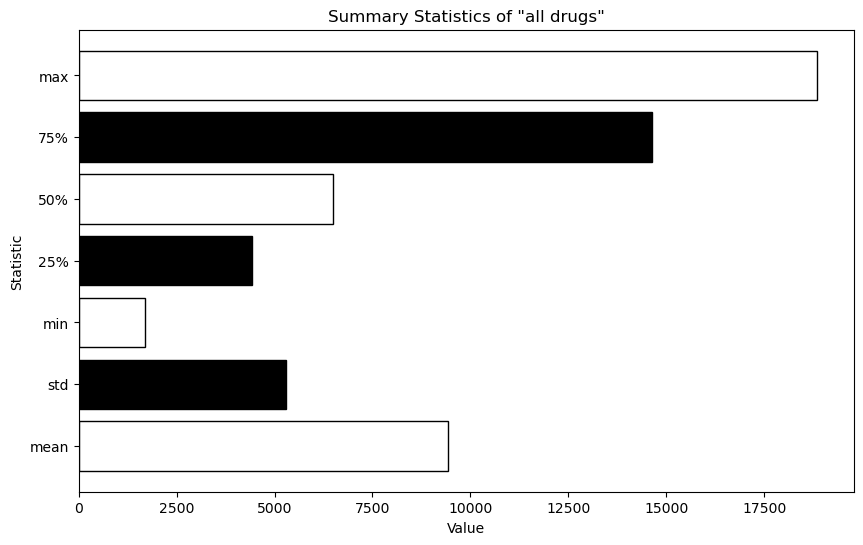

In [51]:
# Extracting the results of describe() for 'all drugs'
describe_results = drug_sex_df['all drugs'].describe()

# Removing the 'count' statistic as it won't fit well in this visualization
describe_results = describe_results.drop('count')

plt.figure(figsize=(10, 6))
# Plot each bar individually to apply hatch conditionally
for i, (statistic, value) in enumerate(describe_results.items()):
    color='white' if i % 2 == 0 else 'black' 
    plt.barh(statistic, value, color=color, edgecolor='black')

plt.title('Summary Statistics of "all drugs"')
plt.xlabel('Value')
plt.ylabel('Statistic')
plt.show()

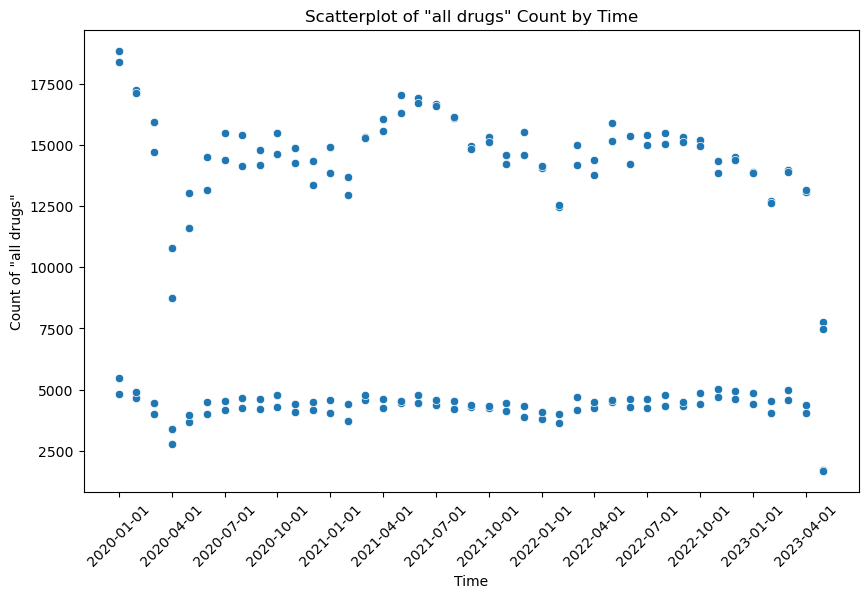

In [52]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=drug_sex_df['start_time'], y=drug_sex_df['all drugs'])
plt.xlabel('Time')
plt.xticks(selected_dates, rotation=45)
plt.ylabel('Count of "all drugs"')
plt.title('Scatterplot of "all drugs" Count by Time')
plt.show()

## Plotting the relationship between 'sex' and 'all drugs'


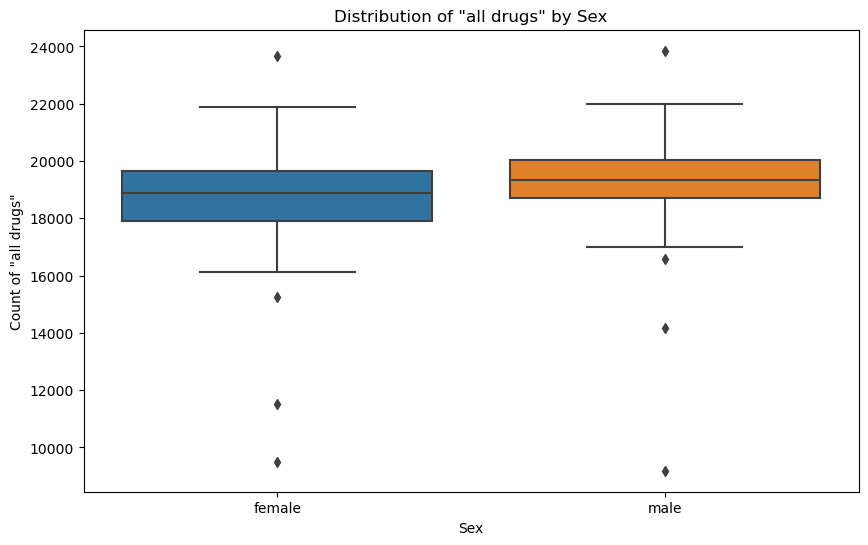

In [53]:
# Grouping patients admitted by setting for each time period
agg_drug_data = drug_sex_df.groupby(['sex', 'start_time'])['all drugs'].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.boxplot(x='sex', y='all drugs', data=agg_drug_data)
plt.title('Distribution of "all drugs" by Sex')
plt.ylabel('Count of "all drugs"')
plt.xlabel('Sex')
plt.show()

## Plotting the relationship between 'setting' and 'all drugs'


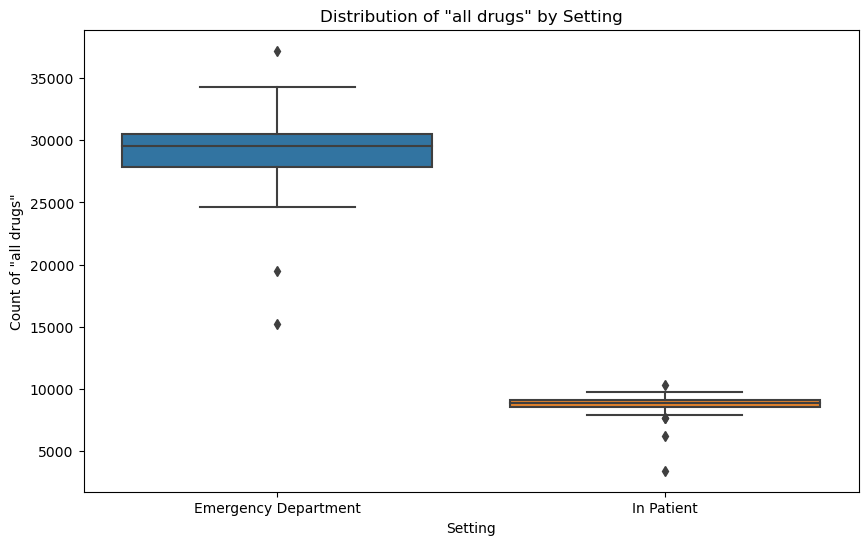

In [54]:
# Grouping patients admitted by setting for each time period
agg_drug_data = drug_sex_df.groupby(['setting', 'start_time'])['all drugs'].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.boxplot(x='setting', y='all drugs', data=agg_drug_data)
plt.title('Distribution of "all drugs" by Setting')
plt.ylabel('Count of "all drugs"')
plt.xlabel('Setting')
plt.show()

## Plotting the relationship between 'time' and 'all drugs'

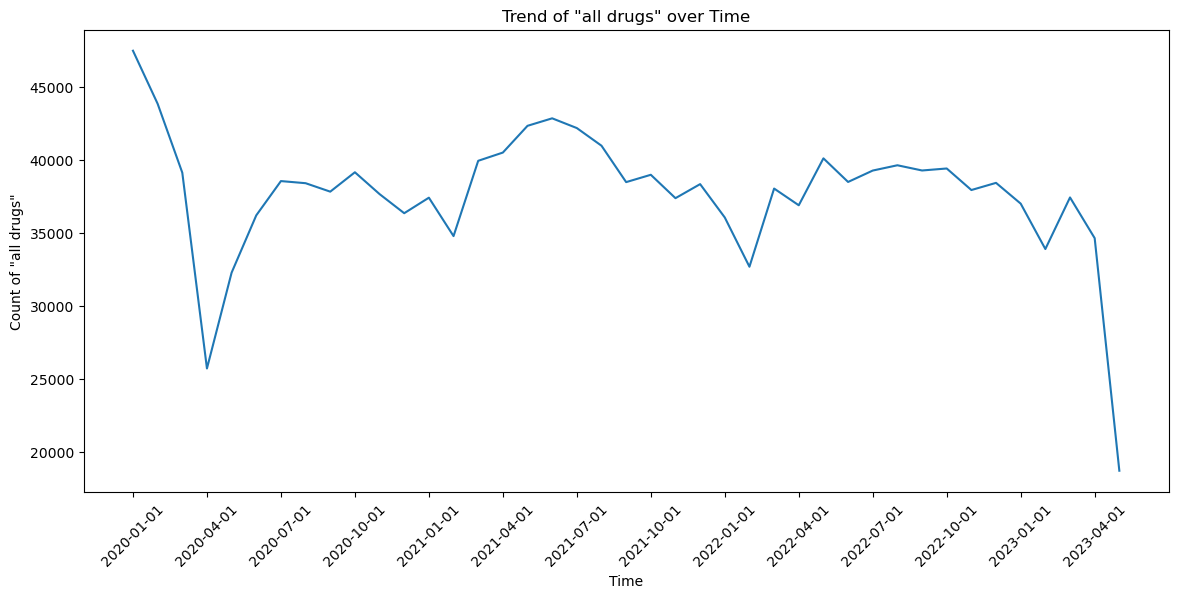

In [55]:

# Aggregate patient and setting numbers to get total count by each month
agg_drug_data = drug_sex_df.groupby('start_time')['all drugs'].sum().reset_index()

plt.figure(figsize=(14, 6))
sns.lineplot(x='start_time', y='all drugs', data=agg_drug_data, ci=None)
plt.title('Trend of "all drugs" over Time')
plt.ylabel('Count of "all drugs"')
plt.xticks(selected_dates, rotation=45)
plt.xlabel('Time')
plt.show()

all drugs


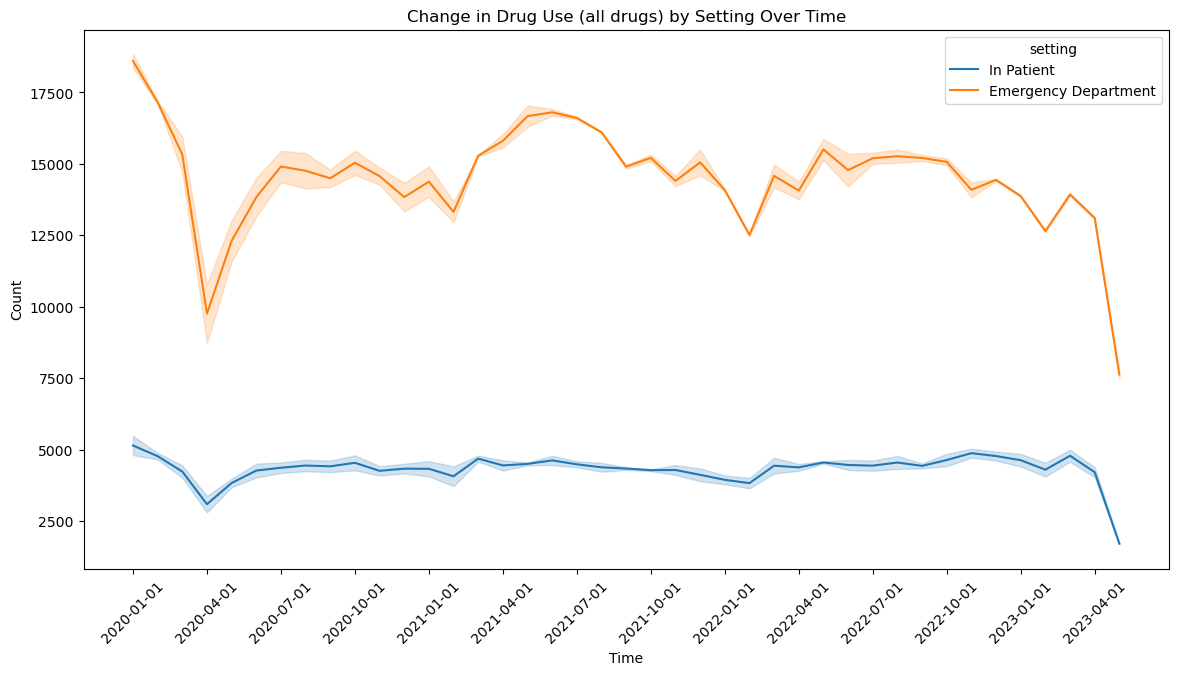

In [56]:
info_columns_to_exclude = ['sex', 'setting', 'time', 'start_time', 'end_time']
for col in drug_sex_df.columns:
    if col not in info_columns_to_exclude:
        print(col)
        plt.figure(figsize=(14, 7))
        sns.lineplot(data=drug_sex_df, x='start_time', y=col, hue='setting')
        title = f"Change in Drug Use ({col}) by Setting Over Time"
        plt.title(title)
        plt.xticks(selected_dates, rotation=45)
        plt.ylabel('Count')
        plt.xlabel('Time')
        plt.show()